# South African Heart Disease
**PAGE 122.** Here we present an analysis of binary data to illustrate the traditional statistical use of the logistic regression model. The data in Figure 4.12 are a subset of the Coronary Risk-Factor Study (CORIS) baseline survey, carried out in three rural areas of the Western Cape, South Africa (Rousseauw et al., 1983). The aim of the study was to establish the intensity of ischemic heart disease risk factors in that high-incidence region. The data represent white males between 15 and 64, and the response variable is the presence or absence of myocardial infarction (MI) at the time of the survey (the overall prevalence of MI was 5.1% in this region). There are 160 cases in our data set, and a sample of 302 controls.

**DATA INFO.** A retrospective sample of males in a heart-disease high-risk region of the Western Cape, South Africa. There are roughly two controls per case of CHD. Many of the CHD positive men have undergone blood pressure reduction treatment and other programs to reduce their risk factors after their CHD event. In some cases the measurements were made after these treatments. These data are taken from a larger dataset, described in  Rousseauw et al, 1983, South African Medical Journal. 

Variables:

|         |                                                       |
|---------|-------------------------------------------------------|
|sbp      |systolic blood pressure                                |
|tobacco  |cumulative tobacco (kg)                                |
|ldl      |low densiity lipoprotein cholesterol                   |
|adiposity|                                                       |
|famhist  |family history of heart disease (Present, Absent)      |
|typea    |type-A behavior                                        |
|obesity  |                                                       |
|alcohol  |current alcohol consumption                            |
|age      |age at onset                                           |
|chd      |response, coronary heart disease                       |

**NOTES.** In the data set we have 160 positive and 302 negative cases (control). That gives a risk estimated of $\tilde{\pi}$ = 0.35. However, the actual prevalence of disease in this region is $\pi$ = 0.05. 5% instead of 35% in the data. If we fit the logistic regression to the data, then the estimated probability will be too high. We can correct the estimated intercept by a simple transformation $\hat{\beta^{*}} = \hat{\beta_{0}} + log\frac{\pi}{1-\pi}-log\frac{\tilde{\pi}}{1-\tilde{\pi}}$. This case-control sampling is one of the favorite tools in epidemiology. Especially when the disease is rare, and we take all cases that we can find. Up to five times that number of controls is sufficient.

A few words about why the case-control sampling is done in this way. It seems that the correct approach is to take few thousand people and follow them for 20 years in order to record the risk factors and see those who get heart disease (5%). The problem is that it takes 20 years. The case-control sampling says let's not do it perspectively like that, but let's rather find people who, as we know, have heart disease or don't have heart disease and sample them in certain proportion and then record risk factors.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import transforms, pyplot as plt
%matplotlib inline

# set common plots properties in advance
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
GRAY4, GRAY7 = '#646369', '#929497'

## Load and Prepare Data

In [2]:
# load training and test data set from a text file
df = pd.read_csv("../data/South African Heart Disease.txt")
# encode famhist with dummy 0-1 variable
df['famhist'] = pd.get_dummies(df['famhist'])['Present']
target = 'chd'
features = ['sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'alcohol', 'age']
df[features + [target]].head()

,sbp,tobacco,ldl,famhist,obesity,alcohol,age,chd
0,160,12.00,5.73,1,25.30,97.20,52,1
1,144,0.01,4.41,0,28.87,2.06,63,1
2,118,0.08,3.48,1,29.14,3.81,46,0
3,170,7.50,6.41,1,31.99,24.26,58,1
4,134,13.60,3.50,1,25.99,57.34,49,1


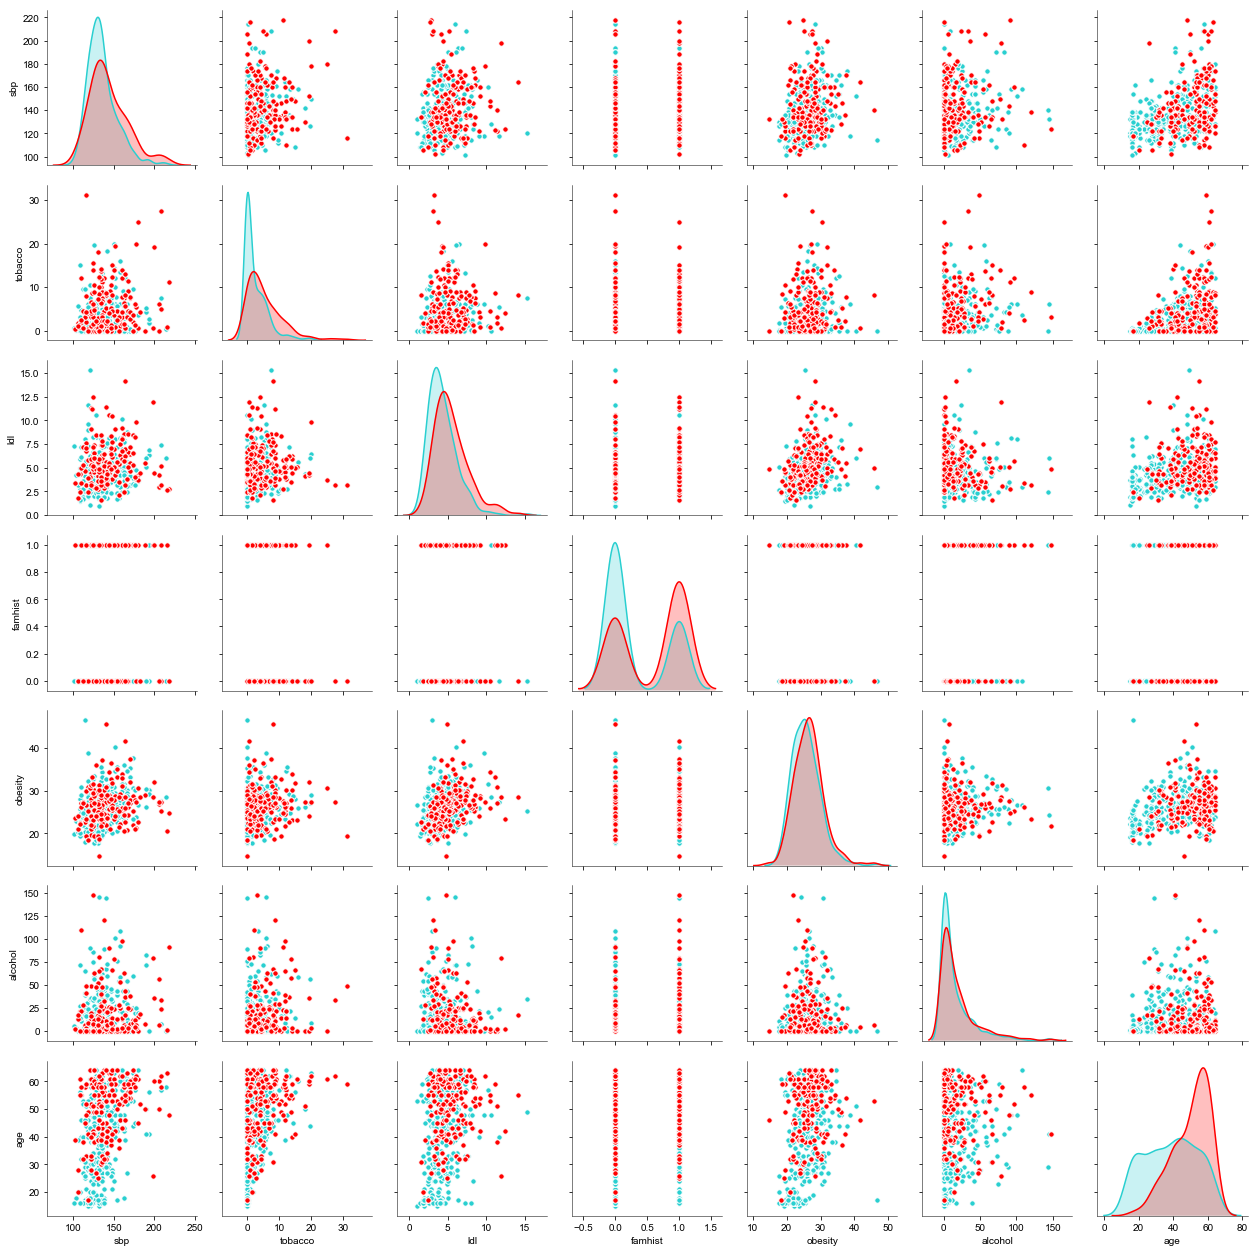

In [3]:
# PAGE 123. FIGURE 4.12. A scatterplot matrix of the South African heart
#           disease data. Each plot shows a pair of risk factors, and the cases
#           and controls are color coded (red is a case). The variable family
#           history of heart disease (famhist) is binary (yes or no).
sns.pairplot(
    df, vars=features, kind="scatter", hue=target,
    palette=['#29CFD0', '#FF0000'], plot_kws=dict(s=30, linewidth=1)
)._legend.remove()

In [4]:
# convert data to X, y np.arrays
X, y = df[features].values, df[target].values

## Logistic Regression

In [5]:
import statsmodels.api as sm
from scipy import stats

In [6]:
# PAGE 122. We fit a logistic-regression model by maximum likelihood, giving
#           the results shown in Table 4.2. This summary includes Z scores for
#           each of the coefficients in the model (coefficients divided by
#           their standard errors); a nonsignificant Z score suggests a
#           coefficient can be dropped from the model. Each of these correspond
#           formally to a test of the null hypothesis that the coefficient in
#           question is zero, while all the others are not (also known as the
#           Wald test). A Z score greater than approximately 2 in absolute
#           value is significant at the 5% level.
lr = sm.Logit(y, sm.add_constant(X)).fit(disp=False)

# PAGE 122. TABLE 4.2. Results from a logistic regression fit to the South
#           African heart disease data.
#           There are some surprises in this table of coefficients, which must
#           be interpreted with caution. Systolic blood pressure (sbp) is not
#           significant! Nor is obesity, and its sign is negative. This
#           confusion is a result of the correlation between the set of
#           predictors. On their own, both sbp and obesity are significant, and
#           with positive sign. However, in the presence of many other
#           correlated variables, they are no longer needed (and can even get a
#           negative sign).
result = zip(['(Intercept)'] + features, lr.params, lr.bse, lr.tvalues)
print('               Coefficient   Std. Error   Z Score')
print('-------------------------------------------------')
for term, coefficient, std_err, z_score in result:
    print(f'{term:>12}{coefficient:>14.3f}{std_err:>13.3f}{z_score:>10.3f}')

               Coefficient   Std. Error   Z Score
-------------------------------------------------
 (Intercept)        -4.130        0.964    -4.283
         sbp         0.006        0.006     1.023
     tobacco         0.080        0.026     3.034
         ldl         0.185        0.057     3.218
     famhist         0.939        0.225     4.177
     obesity        -0.035        0.029    -1.187
     alcohol         0.001        0.004     0.136
         age         0.043        0.010     4.181


## Features Selection
**PAGE 124.** At this stage the analyst might do some model selection; find a subset of the variables that are sufficient for explaining their joint effect on the prevalence of chd. One way to proceed by is to drop the least significant coefficient, and refit the model. This is done repeatedly until no further terms can be dropped from the model.

A better but more time-consuming strategy is to refit each of the models with one variable removed, and then perform an analysis of deviance to decide which variable to exclude. The residual deviance of a fitted model is minus twice its log-likelihood, and the deviance between two models is the difference of their individual residual deviances (in analogy to sums-of squares).

**NOTES.** sklearn has *feature_selection.RFE* for recursive feature elimination. But sklearn doesn't have an implementation for features selection based on residual deviance. Let's implement it ourselves.

In [7]:
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression

In [8]:
# calculates total deviance of a model on a data set
def deviance(X, y, model):
    return 2*log_loss(y, model.predict_proba(X), normalize=False)


# calculates total deviance of a model trained on features subset
def subset_deviance(model, selected_ids):
    X_selected = X[:, sorted(list(selected_ids))]
    model.fit(X_selected, y)
    return deviance(X_selected, y, model)


lr = LogisticRegression(solver='lbfgs', max_iter=100000, C=10e10)
# start with all features selected, store features indices
selected_ids = set(range(len(features)))
current_deviance = subset_deviance(lr, selected_ids)
while True:
    # what would be the total deviance if we remove a feature?
    deviances = [
        (subset_deviance(lr, selected_ids - set([idx])), idx)
        for idx in selected_ids]
    # find a feature to remove to minimize resulting total deviance
    min_deviance, feature_to_remove_idx = min(deviances)
    # the difference between the deviances for the two models follows
    # an approximate chi-squared distribution. Use it for stopping criteria.
    deviance_diff = min_deviance - current_deviance
    p_value = 1 - stats.chi2.cdf(deviance_diff, df=1)
    if p_value < 0.05:
        break
    selected_ids -= set([feature_to_remove_idx])
    current_deviance = min_deviance
    print(f'REMOVE: {features[feature_to_remove_idx]}')

# selected feature names
selected_ids = sorted(list(selected_ids))
features_selected = [features[i] for i in selected_ids]

REMOVE: alcohol
REMOVE: sbp
REMOVE: obesity


In [9]:
# PAGE 124. TABLE 4.3. Results from stepwise logistic regression fit to South
#           African heart disease data.
lr = sm.Logit(y, sm.add_constant(X[:, selected_ids])).fit(disp=False)
result = zip(['(Intercept)']+features_selected, lr.params, lr.bse, lr.tvalues)
print('               Coefficient   Std. Error   Z Score')
print('-------------------------------------------------')
for term, coefficient, std_err, z_score in result:
    print(f'{term:>12}{coefficient:>14.3f}{std_err:>13.3f}{z_score:>10.2f}')

# PAGE 124. How does one interpret a coefficient of 0.081 (Std. Error = 0.026)
#           for tobacco, for example? Tobacco is measured in total lifetime
#           usage in kilograms, with a median of 1.0kg for the controls and
#           4.1kg for the cases. Thus an increase of 1kg in lifetime tobacco
#           usage accounts for an increase in the odds of coronary heart
#           disease of exp(0.081) = 1.084 or 8.4%. Incorporating the standard
#           error we get an approximate 95% confidence interval of
#           exp(0.081 ± 2 × 0.026) = (1.03, 1.14).

               Coefficient   Std. Error   Z Score
-------------------------------------------------
 (Intercept)        -4.204        0.498     -8.44
     tobacco         0.081        0.026      3.16
         ldl         0.168        0.054      3.09
     famhist         0.924        0.223      4.14
         age         0.044        0.010      4.52


## L1 Regularized Logistic Regression

In [10]:
from sklearn.preprocessing import StandardScaler

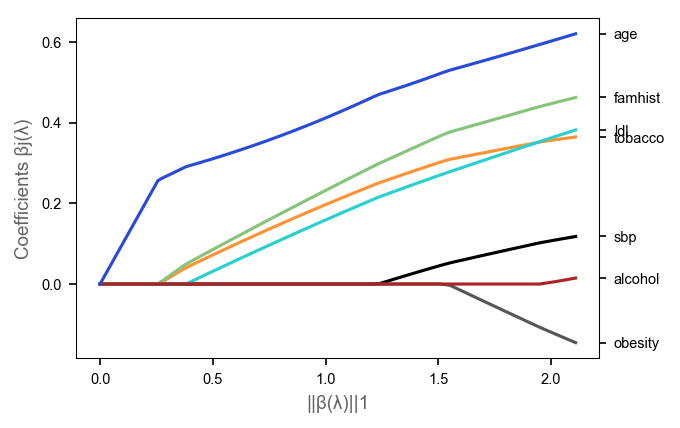

In [11]:
# PAGE 126. The variables were all standardized to have unit variance.
# PAGE 126. FIGURE 4.13. L1 regularized logistic regession coefficients for the
#           South African heart disease data, plotted as a function of the L1
#           norm. The variables were all standardized to have unit variance.
#           The profiles are computed exactly at each of the plotted points.
lr = sm.Logit(y, sm.add_constant(StandardScaler().fit_transform(X)))
# for different alpha values fit a model and save coefficients
alpha = np.linspace(0, 82, 100)
coefs = np.vstack([lr.fit_regularized(disp=False, alpha=a).params[1:]
                   for a in alpha])
# calculate sum of coefficients for different alpha values
coefs_l1_norm = np.sum(np.abs(coefs), axis=1)

fig, ax1 = plt.subplots(figsize=(4.5, 3), dpi=150)
colors = ['#000101', '#FF9234', '#29D0D0', '#85C57A', '#57575A', '#AD2323',
          '#2A4BD7']
for i in range(7):
    ax1.plot(coefs_l1_norm, coefs[:, i], color=colors[i])
ax2 = ax1.twinx()
ax2.set_ylim(ax1.get_ylim())
plt.setp(ax2, yticks=coefs[0], yticklabels=features)
for i in ax1.get_yticklabels() + ax1.get_xticklabels() + ax2.get_yticklabels():
    i.set_fontsize(7)
ax1.set_xlabel('||β(λ)||1', color=GRAY4, fontsize=9)
_ = ax1.set_ylabel('Coefficients βj(λ)', color=GRAY4, fontsize=9)

## Natural Cubic Splines Basis Expansion
I did not find a Python library for natural cubic spline basis expansion and implemented it myself. The class has fit/transform methods and so can be used in pipelines. The formula for the expansion is given on the page 145 (5.4).

$N_{1}(X)=1, N_{2}(X)=X, N_{k+2}(X)=d_{k}(X)-d_{K-1}(X)$,

where $d_{k}(X)=\frac{(X-\xi_{k})_{+}^{3}-(X-\xi_{K})_{+}^{3}}{\xi_{K}-\xi_{k}}$

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from typing import List

In [13]:
class NaturalCubicSplineFeatures(BaseEstimator, TransformerMixin):
    """Generate natural cubic spline and interaction features.
    Parameters
    ----------
    knots :
        Is a list that contains knots list for each feature.
    add_interactions :
        If false, only natural cubic spline features are produced, otherwise
        expanded features interactions are included.
    target_dofs :
        Is a number of degrees of freedom for each feature. If is set, df+1
        knots for features would be automatically calculated at uniform
        quantiles including min and max value of a feature.
    Attributes
    ----------
    dofs_:
        The degrees of freedom for each feature.
    positions_:
        For each feature the index of the first and the last indices of its
        components."""
    def __init__(self, knots: List[List[float]]=None, target_dofs: int=None,
                 add_interactions: bool = False):
        self.knots = knots
        self.add_interactions = add_interactions
        self.target_dofs = target_dofs

    def fit(self, X: np.ndarray,
            y: np.array=None) -> 'NaturalCubicSplineFeatures':
        """Fit NaturalCubicSplineFeatures model according to the given training
           data and parameters.
        Parameters
        ----------
        X :
            Training data.
        y :
            Target values.
        """
        if self.target_dofs is not None:
            quantiles = np.linspace(0, 1, self.target_dofs + 1)
            self.knots = []
            for i in range(X.shape[1]):
                self.knots.append(np.unique(np.quantile(X[:, i], quantiles)))
        # calculate the number of parameters in each component term
        self.dofs_ = np.array([len(k)-1 for k in self.knots])
        # for each feature calculate the first and the last index of expanded
        # basis
        dofs_cumsum = [0] + list(np.cumsum(self.dofs_))
        self.positions_ = [(dofs_cumsum[i-1], dofs_cumsum[i]-1)
                           for i in range(1, len(dofs_cumsum))]
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        """Transform data to natural cubic spline basis expansion
        Parameters
        ----------
        X :
            The data to transform, row by row
        Returns
        -------
        X_new : np.ndarray, shape [n_samples, NN]
            The matrix of features, where NN is the number of natural cubic
            spline features generated from the inputs based on knots.
        """
        features_basis_splines = []
        for i in range(X.shape[1]):
            features_basis_splines.append(
                self.__expand_natural_cubic(X[:, i:i+1], self.knots[i]))
        if self.add_interactions:
            self.__add_interaction_features(features_basis_splines)
        return np.hstack(features_basis_splines)

    @staticmethod
    def __dk(X: np.ndarray, knot: float, knot_last: float) -> np.ndarray:
        return (X - knot).clip(0) ** 3 / (knot_last - knot)

    @staticmethod
    def __expand_natural_cubic(X: np.ndarray, knots: np.array) -> np.ndarray:
        basis_splines = [X]
        dk_last = NaturalCubicSplineFeatures.__dk(X, knots[-2], knots[-1])
        for knot in knots[:-2]:
            dk = NaturalCubicSplineFeatures.__dk(X, knot, knots[-1])
            basis_splines.append(dk - dk_last)
        return np.hstack(basis_splines)

    @staticmethod
    def __add_interaction_features(features_basis_splines):
        features_indices = [list(range(expansion.shape[1]))
                            for expansion in features_basis_splines]
        for combination in itertools.product(*features_indices):
            product = features_basis_splines[0][:, combination[0]].copy()
            for i in range(1, len(combination)):
                product *= features_basis_splines[i][:, combination[i]]
            features_basis_splines.append(np.atleast_2d(product).T)

In [14]:
# PAGE 146. We use four natural spline bases for each term in the model. For
#           example, with X1 representing sbp, h1(X1) is a basis consisting of
#           four basis functions. This actually implies three rather than two
#           interior knots (chosen at uniform quantiles of sbp), plus two
#           boundary knots at the extremes of the data, since we exclude the
#           constant term from each of the hj.
ncs_features = NaturalCubicSplineFeatures(target_dofs=4)
add_intercept = FunctionTransformer(
    lambda X: sm.add_constant(X), validate=True)
data_prep_pipeline = Pipeline([('scale_features', StandardScaler()),
                               ('expand_basis', ncs_features),
                               ('scale_basis', StandardScaler()),
                               ('add_intercept_column', add_intercept)])

# PAGE 146. At this point the model is like any other linear logistic model,
#           and the algorithms described in Section 4.4.1 apply
lr = LogisticRegression(
    solver='lbfgs', max_iter=100000, C=10e10, fit_intercept=False)
expanded_lr = Pipeline([('prepare', data_prep_pipeline),
                        ('logistic', lr)])

In [15]:
# PAGE 146. We carried out a backward stepwise deletion process, dropping terms
#           from this model while preserving the group structure of each term,
#           rather than dropping one coefficient at a time. The AIC statistic
#           (Section 7.5) was used to drop terms, and all the terms remaining
#           in the final model would cause AIC to increase if deleted from the
#           model (see Table 5.1).


# calculates AIC of log-reg model trained on expanded features subset
def subset_aic(selected_ids):
    X_selected = X[:, sorted(list(selected_ids))]
    # expand the basis of the selected features
    X_selected_exp = data_prep_pipeline.fit_transform(X_selected)
    # fit the log-reg model to the expanded data and calculate its AIC
    lr = sm.Logit(
        y, X_selected_exp
    ).fit_regularized(method='l1', maxiter=1000, disp=False)
    return lr.aic

# start with all features selected, store indices
selected_ids = set(range(len(features)))
current_aic = subset_aic(selected_ids)
current_deviance = subset_deviance(lr, selected_ids)
while True:
    stat = [(subset_aic(selected_ids - set([idx])),
             subset_deviance(expanded_lr, selected_ids - set([idx])),
             idx) for idx in selected_ids]
    min_aic, dev, feature_to_remove_idx = min(stat)
    if min_aic > current_aic:
        break
    selected_ids -= set([feature_to_remove_idx])
    current_aic, current_deviance = min_aic, dev
    print(f'REMOVE: {features[feature_to_remove_idx]}')

selected_ids = sorted(list(selected_ids))
# convert list of stats to dictionary
stat = {id: (aic, dev) for (aic, dev, id) in stat}

REMOVE: alcohol


In [16]:
# refit the model to the selected features
X_selected = X[:, selected_ids]
expanded_lr.fit(X_selected, y)
# save min-max of the selected features to use in plotting
X_min, X_max = np.min(X_selected, axis=0), np.max(X_selected, axis=0)

In [17]:
print(f'    Terms   Df   Deviance      AIC      LRT   P-value')
print(f'-----------------------------------------------------')
print(f'     none          {current_deviance:.2f}   {current_aic:.2f}')
for i, feature_idx in enumerate(selected_ids):
    feature_aic, feature_dev = stat[feature_idx]
    lrt = feature_dev - current_deviance
    p_value = 1 - stats.chi2.cdf(lrt, df=ncs_features.dofs_[i])
    print(f'{features[feature_idx]:>9}{ncs_features.dofs_[i]:>4}'
          f'{feature_dev:>12.2f}{feature_aic:9.2f}{lrt:>9.3f} {p_value:9.3f}')

    Terms   Df   Deviance      AIC      LRT   P-value
-----------------------------------------------------
     none          459.54   503.53
      sbp   4      469.33   505.33    9.792     0.044
  tobacco   4      470.48   506.48   10.937     0.027
      ldl   4      474.48   510.48   14.945     0.005
  famhist   1      480.38   522.38   20.839     0.000
  obesity   4      467.93   503.93    8.390     0.078
      age   4      485.76   521.77   26.224     0.000


**PAGE 146.** Figure 5.4 shows a plot of the final model selected by the stepwise regression. The functions displayed are $\hat{f}_j(X_j) = h_j(X_j)^T\hat{\theta}_j$ for each variable $X_j$. The covariance matrix $Cov(\hat{\theta}) = \boldsymbol{\Sigma}$ is estimated by $\hat{\boldsymbol{\Sigma}}= (\boldsymbol{X}^T\boldsymbol{W}\boldsymbol{X})^{-1}$, where $\boldsymbol{W}$ is the diagonal weight matrix from the logistic regression [$w_{ii} = \pi_{i}(1-\pi_{i})$]. Hence $v_j(X_j) = Var[\hat{f}_j(X_j)] = h_j(X_j)^T\boldsymbol{\Sigma}_{jj}h_j(X_j)$ is the pointwise variance function of $\hat{f}_j$, where $Cov(\hat{\theta}_j) = \hat{\boldsymbol{\Sigma}}_{jj}$ is the appropriate sub-matrix of $\hat{\boldsymbol{\Sigma}}$. The shaded region in each panel is defined by $\hat{f}_j(X_j)\pm 2\sqrt{v_j(X_j)}$.

In [18]:
# estimate the covariance matrix
H = data_prep_pipeline.transform(X_selected)
predProbs = expanded_lr.predict_proba(X_selected)
W = np.diagflat(np.product(predProbs, axis=1))
cov = np.linalg.inv(H.T @ W @ H)

# linspace selected features and calculate their basis expansions
x_vals = np.vstack([np.linspace(X_min[i], X_max[i], 100)
                    for i in range(X_min.shape[0])]).T
x_vals_exp = data_prep_pipeline.transform(x_vals)

# drop rows and columns for intercepts
x_vals_exp = x_vals_exp[:, 1:]
cov = cov[1:, 1:]

In [19]:
def plot_term_natural_spline_function(ax, feature_idx, name):
    basis_start, basis_end = ncs_features.positions_[feature_idx]
    # calculate feature expansion matrix, feature cov and feature err
    feature_exp = x_vals_exp[:, basis_start:basis_end+1]
    feature_lr_coef = lr.coef_[:, basis_start+1:basis_end+2].T
    feature_cov = cov[basis_start:basis_end+1, basis_start:basis_end+1]
    feature_err = 2*np.sqrt(np.diag(feature_exp @ feature_cov @ feature_exp.T))
    feature_x_vals = x_vals[:, feature_idx]
    feature_y_vals = np.squeeze(feature_exp @ feature_lr_coef)
    # plot shaded region
    ax.fill_between(feature_x_vals,
                    feature_y_vals - feature_err,
                    feature_y_vals + feature_err,
                    color='#FFEC8B')
    # plot function line
    ax.plot(feature_x_vals, feature_y_vals, color='#00FF00', linewidth=0.8)
    # plot bottom red lines representing samples
    y_from, y_to = ax.get_ylim()
    for i in range(X_selected.shape[0]):
        x = X_selected[i, feature_idx]
        ax.plot([x, x], [y_from, y_from+(y_to-y_from)*0.02],
                color='red', linewidth=0.5)
    ax.set_ylim(y_from, y_to)
    # title the plot and set ticks
    for l in ax.get_yticklabels() + ax.get_xticklabels():
        l.set_fontsize(6)
    ax.set_xlabel(f'{name}', color=GRAY4, fontsize=8)
    ax.set_ylabel(f'f({name})', color=GRAY4, fontsize=8)

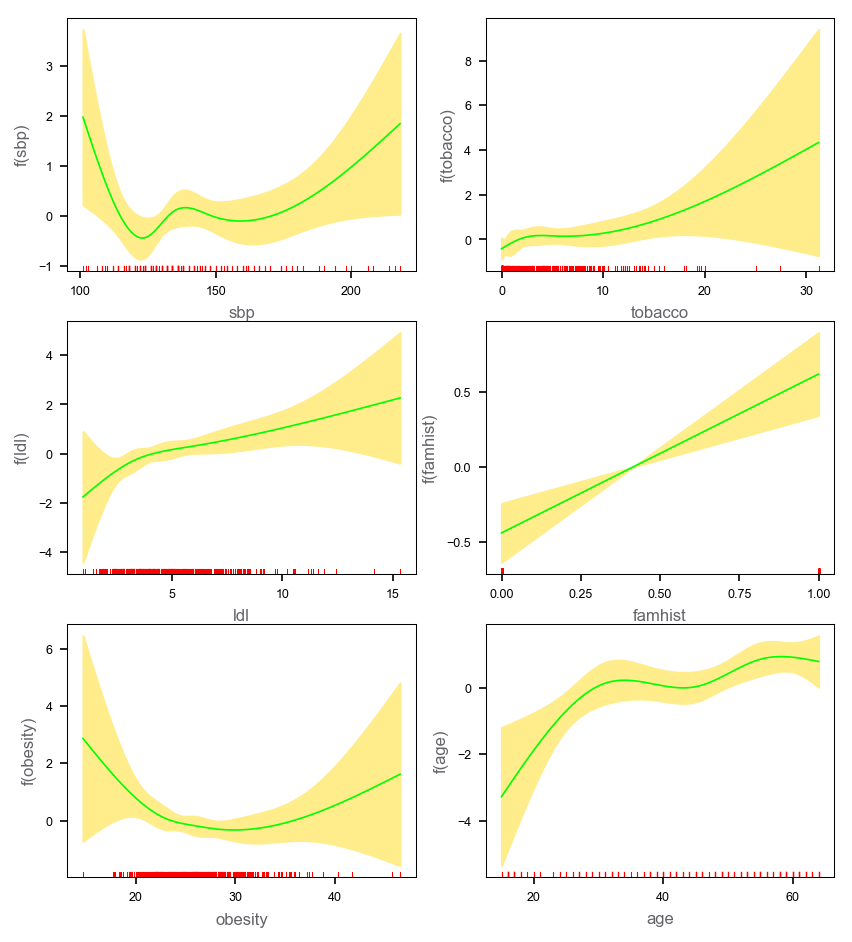

In [20]:
# PAGE 147. FIGURE 5.4. Fitted natural-spline functions for each of the terms
#           in the final model selected by the stepwise procedure. Included are
#           pointwise standard-error bands. The rug plot at the base of each
#           figure indicates the location of each of the sample values for that
#           variable (jittered to break ties).
fig, axarr = plt.subplots(3, 2, figsize=(3.3*2, 2.3*3), dpi=150)
plt.subplots_adjust(bottom=0.05)
plot_term_natural_spline_function(axarr[0, 0], 0, 'sbp')
plot_term_natural_spline_function(axarr[0, 1], 1, 'tobacco')
plot_term_natural_spline_function(axarr[1, 0], 2, 'ldl')
plot_term_natural_spline_function(axarr[1, 1], 3, 'famhist')
plot_term_natural_spline_function(axarr[2, 0], 4, 'obesity')
plot_term_natural_spline_function(axarr[2, 1], 5, 'age')

## Thin-Plate Spline
Scikit-Learn doesn't have an implementation for thin-plate splines. Tried to implement myself, but didn't succeed. Let's use Rbf, its result is similar to the one in the book.

In [21]:
from scipy.spatial import ConvexHull
from scipy.interpolate import Rbf
from matplotlib import cm

In [22]:
# remove 1 outlier because it greatly expands the convex hull
df1 = df[~((df.age < 20) & (df.obesity > 45))]
age_vals = df1.age.values.astype(np.float64)
obesity_vals = df1.obesity.values.astype(np.float64)
sbp_vals = df1.sbp.values.astype(np.float64)

# build a convex hull
hull = ConvexHull(np.vstack((age_vals, obesity_vals)).T)

In [23]:
# checks whether a point is inside a convex hull
def point_in_hull(point, hull, tolerance=1e-12):
    return all((np.dot(eq[:-1], point) + eq[-1] <= tolerance)
               for eq in hull.equations)

grid_size = 500
# calculate approximation on whole x-y range
age_grid, obesity_grid = np.meshgrid(
    np.linspace(np.min(age_vals), np.max(age_vals), grid_size),
    np.linspace(np.min(obesity_vals), np.max(obesity_vals), grid_size))
sbp_mean = np.mean(sbp_vals)
rbf = Rbf(age_vals, obesity_vals, sbp_vals - sbp_mean,
          smooth=30, function='multiquadric')
sbp_grid = rbf(age_grid, obesity_grid) + sbp_mean

# remove all points outside the convex hull
for i in range(grid_size):
    for j in range(grid_size):
        if not point_in_hull([age_grid[i, j], obesity_grid[i, j]], hull):
            sbp_grid[i, j] = None

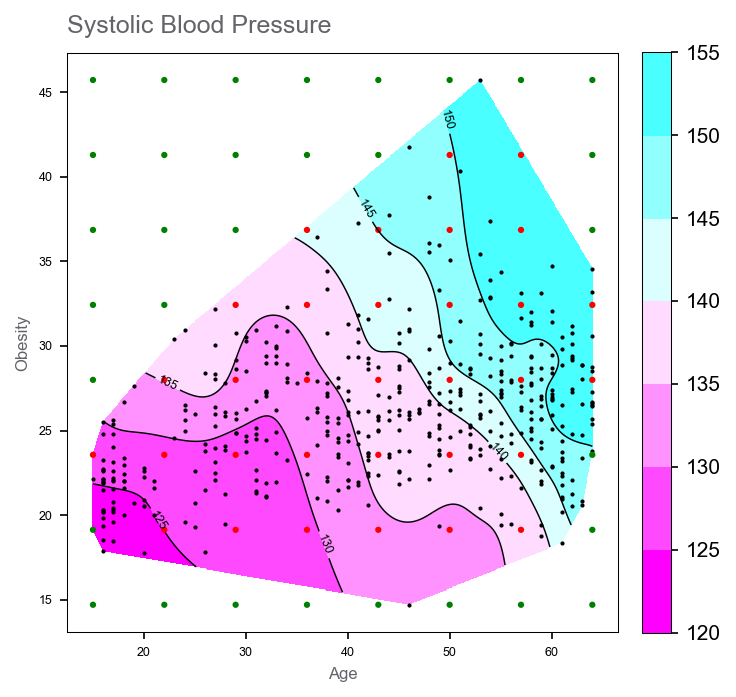

In [24]:
# PAGE 166. FIGURE 5.12. A thin-plate spline fit to the heart disease data,
#           displayed as a contour plot. The response is systolic blood
#           pressure, modeled as a function of age and obesity. The data points
#           are indicated, as well as the lattice of points used as knots. Care
#           should be taken to use knots from the lattice inside the convex
#           hull of the data (red), and ignore those outside (green).
levels = [120, 125, 130, 135, 140, 145, 150, 155]
colors = ['#FF00FF', '#FF49FF', '#FF92FF', '#FFDBFF',
          '#DBFFFF', '#92FFFF', '#49FFFF', '#00FFFF']
fig, ax = plt.subplots(figsize=(5.2, 5.2), dpi=150)
cf = ax.contourf(
    age_grid, obesity_grid, sbp_grid, levels=levels, colors=colors)
cs = ax.contour(age_grid, obesity_grid, sbp_grid, levels=levels,
                colors='black', linewidths=0.7)
ax.clabel(cs, inline=1, fontsize=6, fmt='%1.0f')
ax.scatter(age_vals, obesity_vals, s=1, color='black')
ax.set_aspect(1.66)
latice = np.transpose([np.tile(np.linspace(15, 64, 8), 8),
                       np.repeat(np.linspace(14.7, 45.72, 8), 8)])
colors = [('green', 'red')[point_in_hull(latice[i], hull)]
          for i in range(latice.shape[0])]
ax.scatter(latice[:, 0], latice[:, 1], s=4, color=colors)
for l in ax.get_yticklabels() + ax.get_xticklabels():
    l.set_fontsize(6)
ax.set_xlabel('Age', color=GRAY4, fontsize=8)
ax.set_ylabel('Obesity', color=GRAY4, fontsize=8)
fig.colorbar(cf, ax=ax, fraction=0.048, pad=0.04)
_ = ax.text(12.5, 48.5, 'Systolic Blood Pressure', color=GRAY4, fontsize=12)

## Local Logistic Regression
**PAGE 210.** The local logistic regression method (6.20) uses the tri-cube kernel with k-NN bandwidth; this effectively widens the kernel in this region, and makes use of the local linear assumption to smooth out the estimate (on the logit scale).    

Scikit-Learn doesn't have local regression implemented. Let's implement it ourselves.

In [25]:
from sklearn.utils import resample
from scipy.spatial.distance import cdist

In [26]:
class LocalRegression(BaseEstimator):
    """Local regression model with tri-cube kernel and k-NN bandwidth.
    Parameters
    ----------
        model :
            Underlying model to fit. Should have fit method with weights and
            predict and/or predict_proba methods.
        kernel_size :
            The number or a fraction of nearest points to be in the kernel.
    """
    def __init__(self, model, kernel_size: int=1):
        self.model = model
        self.kernel_size = kernel_size

    def fit(self,
            X: np.ndarray, y: np.array=None) -> 'LocalRegression':
        self.X, self.y = X, y
        return self

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        return self.__predict(X, self.model.predict_proba)

    def predict(self, X: np.ndarray) -> np.ndarray:
        return self.__predict(X, self.model.predict)

    def __predict(self, X: np.ndarray, fnc) -> np.ndarray:
        result = []
        for i in range(X.shape[0]):
            self.model.fit(
                self.X, self.y,
                sample_weight=self.__tri_cube_kernel(X[i:i + 1, :]))
            result.append(np.atleast_2d(fnc([X[i]])))
        return np.vstack(result)

    def __tri_cube_kernel(self, x0):
        points_cnt = self.kernel_size
        if points_cnt <= 1:
            points_cnt = int(self.X.shape[0] * points_cnt)
        distances = cdist(self.X, x0)
        kernel_points_indices = np.argpartition(
            distances, points_cnt, axis=0)[:points_cnt]
        max_distance = np.max(distances[kernel_points_indices])
        relative_distance = distances/max_distance
        result = (relative_distance <= 1)*(1-relative_distance**3)**3
        return np.squeeze(result)

In [27]:
# bootstrap for the confidence intervals
def bootstrap_local_logistic_regression(X, y, X_, k):
    result = np.zeros(shape=(100, X_.shape[0]))
    lr = LocalRegression(
        model=LogisticRegression(
            solver='lbfgs', max_iter=100000, C=10e10, fit_intercept=True),
        kernel_size=k)
    for i in range(result.shape[0]):
        lr.fit(*resample(X, y))
        result[i] = lr.predict_proba(X_)[:, 1]
    return np.percentile(result, [16, 50, 84], axis=0)

In [28]:
# target values
chd_vals = df.chd.values

# bootstrap local linear regression for sbp
sbp_vals = df[['sbp']].values.astype(np.float64)
sbp_spaced = np.linspace(
    np.min(sbp_vals), np.max(sbp_vals), 100).reshape(100, 1)
sbp_conf_intervals = bootstrap_local_logistic_regression(
    sbp_vals, chd_vals, sbp_spaced, 300)

# bootstrap local linear regression for obesity
obesity_vals = df[['obesity']].values.astype(np.float64)
obesity_spaced = np.linspace(
    np.min(obesity_vals), np.max(obesity_vals), 100).reshape(100, 1)
obesity_conf_intervals = bootstrap_local_logistic_regression(
    obesity_vals, chd_vals, obesity_spaced, 300)

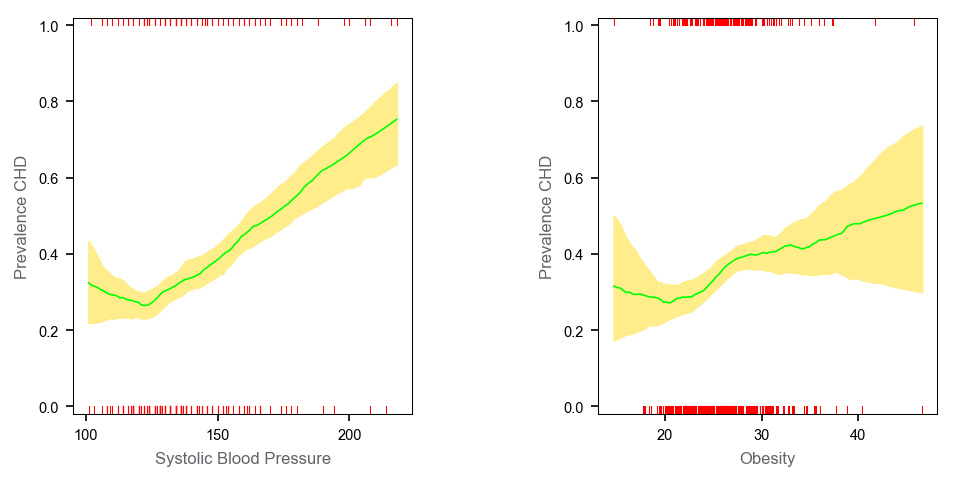

In [29]:
# PAGE 207. FIGURE 6.12. Each plot shows the binary response CHD (coronary
#           heart disease) as a function of a risk factor for the South African
#           heart disease data. For each plot we have computed the fitted
#           prevalence of CHD using a local linear logistic regression model.
#           The unexpected increase in the prevalence of CHD at the lower ends
#           of the ranges is because these are retrospective data, and some of
#           the subjects had already undergone treatment to reduce their blood
#           pressure and weight. The shaded region in the plot indicates an
#           estimated pointwise standard
#           error band.
def plot_local_regression_result(ax, x_label, x_spaced, x_vals,
                                 conf_intervals):
    ax.fill_between(
        x_spaced[:, 0], conf_intervals[0], conf_intervals[2], color='#FFEC8B')
    ax.plot(x_spaced[:, 0], conf_intervals[1], color='#00FF00', linewidth=0.8)
    for i in range(x_vals.shape[0]):
        y_from = (-0.02, 1)[y[i]]
        ax.plot([x_vals[i, 0], x_vals[i, 0]],
                [y_from, y_from+0.02],
                color='red', linewidth=0.5)
    for i in ax.get_yticklabels() + ax.get_xticklabels():
        i.set_fontsize(7)
    ax.set_ylim(-0.02, 1.02)
    ax.set_xlabel(x_label, color=GRAY4, fontsize=8)
    ax.set_ylabel('Prevalence CHD', color=GRAY4, fontsize=8)


fig, axarr = plt.subplots(1, 2, figsize=(7.2, 3.5), dpi=150)
plt.subplots_adjust(
    left=0.1, bottom=None, right=None, top=None, wspace=0.55, hspace=None)
plot_local_regression_result(
    axarr[0], 'Systolic Blood Pressure', sbp_spaced, sbp_vals,
    sbp_conf_intervals)
plot_local_regression_result(
    axarr[1], 'Obesity', obesity_spaced, obesity_vals, obesity_conf_intervals)

## Kernel Density Estimation and Classification

In [30]:
from sklearn.neighbors import KernelDensity

In [31]:
sbp_vals_chd = df[df.chd == 1][['sbp']].values.astype(np.float64)
sbp_vals_nochd = df[df.chd == 0][['sbp']].values.astype(np.float64)
prior_pos = sbp_vals_chd.size/(sbp_vals_chd.size + sbp_vals_nochd.size)
prior_neg = 1 - prior_pos

In [32]:
kde = KernelDensity(kernel='gaussian', bandwidth=5.5)
chd_dens = np.exp(kde.fit(sbp_vals_chd).score_samples(sbp_spaced))
nochd_dens = np.exp(kde.fit(sbp_vals_nochd).score_samples(sbp_spaced))
posterior_prop = prior_pos*chd_dens/(prior_pos*chd_dens+prior_neg*nochd_dens)

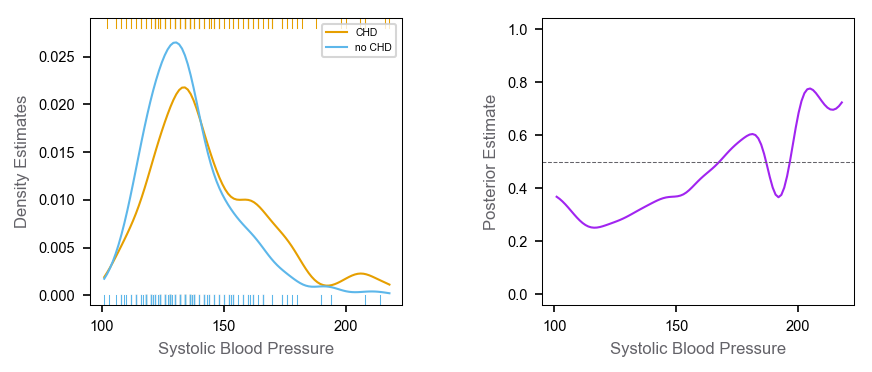

In [33]:
# PAGE 209. FIGURE 6.14. The left panel shows the two separate density
#           estimates for systolic blood pressure in the CHD versus no-CHD
#           groups, using a Gaussian kernel density estimate in each. The right
#           panel shows the estimated posterior probabilities for CHD, using
#           (6.25).
fig, axarr = plt.subplots(1, 2, figsize=(6.37, 2.53), dpi=150)
plt.subplots_adjust(
    left=0.1, bottom=None, right=None, top=None, wspace=0.45, hspace=None)
axarr[0].plot(sbp_spaced, chd_dens, color='#E69F00', linewidth=1, label='CHD')
axarr[0].plot(
    sbp_spaced, nochd_dens, color='#5DB7EA', linewidth=1, label='no CHD')
axarr[1].plot(sbp_spaced, posterior_prop, color='#A124F0', linewidth=1)
axarr[0].set_xlabel('Systolic Blood Pressure', color=GRAY4, fontsize=8)
axarr[0].set_ylabel('Density Estimates', color=GRAY4, fontsize=8)
axarr[1].set_xlabel('Systolic Blood Pressure', color=GRAY4, fontsize=8)
axarr[1].set_ylabel('Posterior Estimate', color=GRAY4, fontsize=8)
axarr[0].legend(loc='upper right', prop={'size': 5})
axarr[1].axhline(y=0.5, c=GRAY4, linewidth=0.5, linestyle='--')
axarr[0].set_xlim(95, 223)
axarr[1].set_xlim(95, 223)
axarr[1].set_ylim(-0.04, 1.04)
for ax in [axarr[0], axarr[1]]:
    for i in ax.get_yticklabels() + ax.get_xticklabels():
        i.set_fontsize(7)

for i in range(sbp_vals.size):
    y_from = (-0.001, 0.028)[y[i]]
    axarr[0].plot([sbp_vals[i, 0], sbp_vals[i, 0]],
                  [y_from, y_from+0.001],
                  color=('#5DB7EA', '#E69F00')[y[i]], linewidth=0.5)
_ = axarr[0].set_ylim(-0.001, 0.029)        

## Mixture Models for Density Estimation and Classification

In [34]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [35]:
# PAGE 214. Using the combined data, we fit a two-component mixture of the form
#           (6.32) with the (scalars) Σ1 and Σ2 not constrained to be equal.
#           Fitting was done via the EM algorithm (Chapter 8): note that the
#           procedure does not use knowledge of the CHD labels.
age_vals = df[['age']].values.astype(np.float64)
age_vals_nochd = df[df.chd == 0].age.values.astype(np.float64)
age_vals_chd = df[df.chd == 1].age.values.astype(np.float64)
age_spaced = np.linspace(np.min(age_vals), np.max(age_vals), 100)
gm = GaussianMixture(
    n_components=2,
    covariance_type='spherical',
    means_init=[[10], [90]],
    random_state=1
).fit(age_vals)
nochd_rv = norm(loc=gm.means_[0], scale=np.sqrt(gm.covariances_[0]))
chd_rv = norm(loc=gm.means_[1], scale=np.sqrt(gm.covariances_[1]))

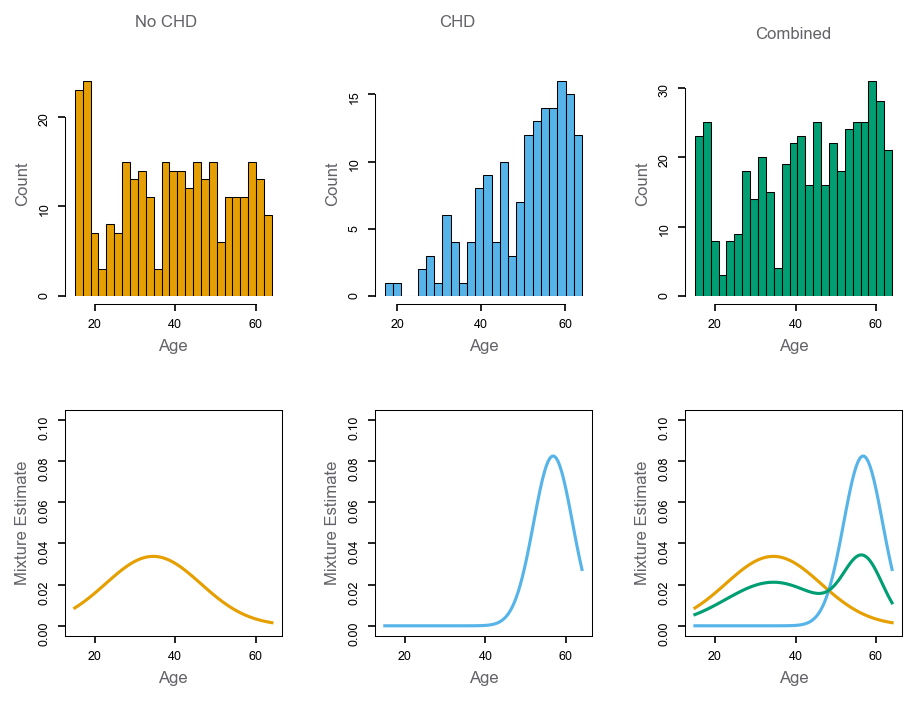

In [36]:
# PAGE 215. FIGURE 6.17. Application of mixtures to the heart disease
#           risk-factor study. (Top row:) Histograms of Age for the no CHD and
#           CHD groups separately, and combined. (Bottom row:) estimated
#           component densities from a Gaussian mixture model, (bottom left,
#           bottom middle); (bottom right:) Estimated component densities (blue
#           and orange) along with the estimated mixture density (green). The
#           orange density has a very large standard deviation, and
#           approximates a uniform density.
fig, axarr = plt.subplots(2, 3, figsize=(7.2, 5), dpi=150)
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.43, hspace=0.5)
axarr[0, 0].hist(
    age_vals_nochd, bins=25, edgecolor='black', linewidth=0.5, color='#E69F00')
axarr[0, 1].hist(
    age_vals_chd, bins=24, edgecolor='black', linewidth=0.5, color='#56B4E9')
axarr[0, 2].hist(
    age_vals, bins=25, edgecolor='black', linewidth=0.5, color='#009E73')
axarr[1, 0].plot(age_spaced, nochd_rv.pdf(age_spaced), color='#E69F00')
axarr[1, 1].plot(age_spaced, chd_rv.pdf(age_spaced), color='#56B4E9')
axarr[1, 2].plot(age_spaced, nochd_rv.pdf(age_spaced), color='#E69F00')
axarr[1, 2].plot(age_spaced, chd_rv.pdf(age_spaced), color='#56B4E9')
axarr[1, 2].plot(
    age_spaced,
    gm.weights_[0]*nochd_rv.pdf(age_spaced) +
    gm.weights_[1]*chd_rv.pdf(age_spaced),
    color='#009E73')

offset = transforms.ScaledTranslation(0, -0.05, fig.dpi_scale_trans)
for i in range(3):
    axarr[1, i].set_ylim(-0.005, 0.105)
    axarr[0, i].spines['right'].set_visible(False)
    axarr[0, i].spines['top'].set_visible(False)
    axarr[0, i].spines['bottom'].set_bounds(20, 60)
    axarr[0, i].spines['left'].set_bounds(0, (20, 15, 30)[i])
    for item in [axarr[0, i].spines['bottom']] + \
                axarr[0, i].get_xticklabels() + \
                axarr[0, i].xaxis.get_ticklines():
        item.set_transform(item.get_transform() + offset)
    axarr[0, i].set_xlabel('Age', color=GRAY4, fontsize=8)
    axarr[1, i].set_xlabel('Age', color=GRAY4, fontsize=8)
    axarr[0, i].set_ylabel('Count', color=GRAY4, fontsize=8)
    axarr[1, i].set_ylabel('Mixture Estimate', color=GRAY4, fontsize=8)
    plt.setp(axarr[1, i], yticks=[0.00, 0.02, 0.04, 0.06, 0.08, 0.10])
    for ax in [axarr[0, i], axarr[1, i]]:
        for i in ax.get_yticklabels() + ax.get_xticklabels():
            i.set_fontsize(6)
        for i in ax.get_yticklabels():
            i.set_rotation(90)
axarr[0, 0].text(30, 30, 'No CHD', color=GRAY4, fontsize=8)
axarr[0, 1].text(30, 20, 'CHD', color=GRAY4, fontsize=8)
_ = axarr[0, 2].text(30, 37, 'Combined', color=GRAY4, fontsize=8)

In [37]:
# PAGE 215. Although the mixture model did not use the CHD labels, it has done
#           a fair job in discovering the two CHD subpopulations. Linear
#           logistic regression, using the CHD as a response, achieves the same
#           error rate (32%) when fit to these data using maximum-likelihood
#           (Section 4.4).
y_hat = gm.predict(age_vals)
cm = confusion_matrix(y, y_hat)
print(f'           | Mixture model')
print(f'           |  δ = 0  δ = 1')
print(f'--------------------------')
print(f'CHD    No  |    {cm[0,0]}     {cm[0,1]}')
print(f'       Yes |     {cm[1,0]}     {cm[1,1]}')
print(f'\n Error rate: {1 - accuracy_score(y, y_hat):.2f}')

           | Mixture model
           |  δ = 0  δ = 1
--------------------------
CHD    No  |    221     81
       Yes |     61     99

 Error rate: 0.31
